In [6]:

import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

# import change_point_analysis as cpa
# import change_point_plot as cpp

In [7]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [8]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [9]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)


load *SessionPulses.Events.mat failed


In [10]:
import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



<module 'sys' (built-in)>
<module 'sys' (built-in)>
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_2

In [157]:
normalize=True
X_restacked_df_d=nmf_res_d[(normalize,1,True)]['X_normed_restacked_df_d']
W_df_peaks_only_d=nmf_res_d[(normalize,1,True)]['W_df_peaks_only_d']

key=(0,0)
X_peaks = X_restacked_df_d[key].loc[W_df_peaks_only_d[key].index]
sigma=1
X_peaks_smth = scipy.ndimage.gaussian_filter1d(X_peaks,sigma,axis=1)
X_peaks_smth = pd.DataFrame(X_peaks_smth,index=X_peaks.index,columns=X_peaks.columns)

In [156]:
X_peaks

trial                1.0        3.0        6.0        8.0        10.0  \
    lin_binned                                                          
1   7            0.000000   0.000000   1.304348   0.389610   0.000000   
3   3            0.000000   0.000000   0.789474   0.000000   0.810811   
27  1            9.230769  17.500000  31.999999  17.142857  32.142857   
    7           27.692307  38.999999  24.782608  22.987013  25.499999   
29  2           16.153846  16.153846  29.999999  25.999999   0.000000   
...                   ...        ...        ...        ...        ...   
478 1            0.000000   0.000000   0.000000   0.000000   0.000000   
    4            0.000000   0.000000   0.000000   0.000000   0.000000   
479 6            0.000000   0.000000   0.000000   0.000000   3.214286   
480 3            0.000000   0.750000   0.000000   0.000000   0.000000   
    8            1.607143  13.125000   2.027027  13.448276   8.478261   

trial                12.0       14.0       16.0       18.0       20.0  ...  \
    lin_binned                                                         ...   
1   7            0.000000   0.000000   0.000000   0.000000   0.000000  ...   
3   3            0.000000   0.000000   0.000000   0.000000   1.914894  ...   
27  1           14.117647  31.666666  23.571428  20.769230  19.285714  ...   
    7           16.956521  27.777777  22.173913  31.249999  24.545454  ...   
29  2            5.625000   8.333333   4.285714  10.000000  17.500000  ...   
...                   ...        ...        ...        ...        ...  ...   
478 1            0.000000   0.000000   0.000000   0.000000   0.000000  ...   
    4            0.000000   0.000000   0.000000   2.142857   0.000000  ...   
479 6            0.000000   5.000000   0.000000   0.000000   0.000000  ...   
480 3            2.000000   0.000000   0.000000   0.000000   0.638298  ...   
    8           18.529411   5.393258   6.835443   6.923077   9.130435  ...   

trial                49.0       51.0       53.0       55.0       57.0  \
    lin_binned                                                          
1   7            0.000000   0.000000   0.000000   0.000000   0.000000   
3   3            1.714286   1.818182   2.368421   2.884615   3.000000   
27  1           29.999999  34.285714  35.624999  25.909090  24.375000   
    7           13.500000  34.468084  31.176470  29.999999  28.378378   
29  2           15.882353  16.000000  21.666666  18.750000  11.250000   
...                   ...        ...        ...        ...        ...   
478 1            0.000000   0.000000   1.875000   0.000000   0.000000   
    4            0.000000   0.000000   0.000000   0.000000   0.000000   
479 6            0.000000   0.594059   1.348315   0.000000   0.000000   
480 3            0.000000   0.000000   0.000000   0.000000   0.000000   
    8           14.727272   7.912088   5.590062   7.758621  16.829268   

trial                59.0       61.0       63.0       65.0       68.0  
    lin_binned                                                         
1   7            0.000000   0.000000   0.000000   0.000000   0.000000  
3   3            3.333333   2.812500   1.463415   1.558442   3.750000  
27  1           28.124999  37.999999  18.000000  16.956521  14.000000  
    7           21.923076   9.600000  23.636363  24.583333  26.249999  
29  2            5.625000   3.750000  12.000000  10.000000  11.538461  
...                   ...        ...        ...        ...        ...  
478 1            0.000000   0.000000   0.000000   0.000000   0.000000  
    4            0.000000   0.000000   0.000000   0.000000   0.000000  
479 6            0.000000   0.000000   0.000000   0.000000   0.000000  
480 3            0.000000   0.000000   0.000000   0.000000   0.750000  
    8            7.058823  23.333333  17.307692   0.000000   3.566433  

[775 rows x 33 columns]

In [13]:
import hmmlearn
import hmmlearn.hmm
from hmmlearn.hmm import GaussianHMM

In [41]:
model=GaussianHMM(n_components=4)

In [42]:
X_peaks

trial                1.0        3.0        6.0        8.0        10.0  \
    lin_binned                                                          
1   7            0.000000   0.000000   1.304348   0.389610   0.000000   
3   3            0.000000   0.000000   0.789474   0.000000   0.810811   
27  1            9.230769  17.500000  31.999999  17.142857  32.142857   
    7           27.692307  38.999999  24.782608  22.987013  25.499999   
29  2           16.153846  16.153846  29.999999  25.999999   0.000000   
...                   ...        ...        ...        ...        ...   
478 1            0.000000   0.000000   0.000000   0.000000   0.000000   
    4            0.000000   0.000000   0.000000   0.000000   0.000000   
479 6            0.000000   0.000000   0.000000   0.000000   3.214286   
480 3            0.000000   0.750000   0.000000   0.000000   0.000000   
    8            1.607143  13.125000   2.027027  13.448276   8.478261   

trial                12.0       14.0       16.0       18.0       20.0  ...  \
    lin_binned                                                         ...   
1   7            0.000000   0.000000   0.000000   0.000000   0.000000  ...   
3   3            0.000000   0.000000   0.000000   0.000000   1.914894  ...   
27  1           14.117647  31.666666  23.571428  20.769230  19.285714  ...   
    7           16.956521  27.777777  22.173913  31.249999  24.545454  ...   
29  2            5.625000   8.333333   4.285714  10.000000  17.500000  ...   
...                   ...        ...        ...        ...        ...  ...   
478 1            0.000000   0.000000   0.000000   0.000000   0.000000  ...   
    4            0.000000   0.000000   0.000000   2.142857   0.000000  ...   
479 6            0.000000   5.000000   0.000000   0.000000   0.000000  ...   
480 3            2.000000   0.000000   0.000000   0.000000   0.638298  ...   
    8           18.529411   5.393258   6.835443   6.923077   9.130435  ...   

trial                49.0       51.0       53.0       55.0       57.0  \
    lin_binned                                                          
1   7            0.000000   0.000000   0.000000   0.000000   0.000000   
3   3            1.714286   1.818182   2.368421   2.884615   3.000000   
27  1           29.999999  34.285714  35.624999  25.909090  24.375000   
    7           13.500000  34.468084  31.176470  29.999999  28.378378   
29  2           15.882353  16.000000  21.666666  18.750000  11.250000   
...                   ...        ...        ...        ...        ...   
478 1            0.000000   0.000000   1.875000   0.000000   0.000000   
    4            0.000000   0.000000   0.000000   0.000000   0.000000   
479 6            0.000000   0.594059   1.348315   0.000000   0.000000   
480 3            0.000000   0.000000   0.000000   0.000000   0.000000   
    8           14.727272   7.912088   5.590062   7.758621  16.829268   

trial                59.0       61.0       63.0       65.0       68.0  
    lin_binned                                                         
1   7            0.000000   0.000000   0.000000   0.000000   0.000000  
3   3            3.333333   2.812500   1.463415   1.558442   3.750000  
27  1           28.124999  37.999999  18.000000  16.956521  14.000000  
    7           21.923076   9.600000  23.636363  24.583333  26.249999  
29  2            5.625000   3.750000  12.000000  10.000000  11.538461  
...                   ...        ...        ...        ...        ...  
478 1            0.000000   0.000000   0.000000   0.000000   0.000000  
    4            0.000000   0.000000   0.000000   0.000000   0.000000  
479 6            0.000000   0.000000   0.000000   0.000000   0.000000  
480 3            0.000000   0.000000   0.000000   0.000000   0.750000  
    8            7.058823  23.333333  17.307692   0.000000   3.566433  

[775 rows x 33 columns]

In [43]:
model.fit(X_peaks.T)

GaussianHMM(n_components=4)

In [44]:
model.decode(X_peaks.T)

(-22593.475067356496,
 array([0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 1]))

In [107]:
state_relabel

array([0, 2, 1, 3])

In [112]:
predicted_state_one

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3])

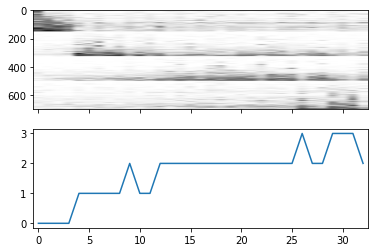

In [242]:
model=GaussianHMM(n_components=4)
model.fit(X_peaks.T)
predicted_state=model.predict_proba(X_peaks.T)
state_relabel=na.sort_by_peak_within_factor(predicted_state.T)[0]
predicted_state = predicted_state[:,state_relabel]
predicted_state_one = np.argmax(predicted_state,axis=1)


emission =model.means_[state_relabel]
clust=np.argmax(model.means_[state_relabel],axis=0)

# idx=np.argsort(clust)
# X_peaks.iloc[idx]
emission_df = pd.DataFrame(emission.T,index=X_peaks.index)
emission_df['clust'] = clust
field_mask = (emission_df > 0.2).any(axis=1)

# field_mask=np.any(model.means_[state_relabel]>0.2,axis=0)
field_sorted_inds= na.sort_factors(emission.T)[0]

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].imshow(X_peaks.iloc[field_sorted_inds].loc[field_mask],aspect='auto')
# plt.colorbar()
axs[1].plot(predicted_state_one)

<AxesSubplot:xlabel='trial'>

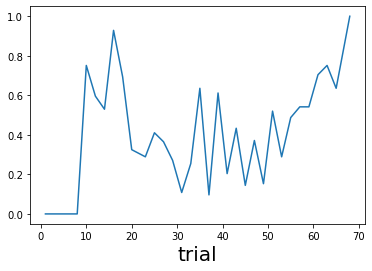

In [245]:
X_peaks.loc[297,2].plot()

In [247]:
X_peaks.max(axis=1)

     lin_binned
1    7             1.000000
3    3             1.000000
27   1             1.000000
     7             0.832000
29   2             1.000000
                     ...   
478  1             0.515625
     4             0.589286
479  6             0.432099
480  3             0.153061
     8             1.000000
Length: 775, dtype: float64

In [277]:
max_ratio_low = 0.1
below_low=X_peaks < np.max(X_peaks.values,axis=1,keepdims=True) * max_ratio_low

In [278]:
max_ratio_high = 0.4
above_high=X_peaks > np.max(X_peaks.values,axis=1,keepdims=True) * max_ratio_high

In [279]:
switch_on=below_low.shift(1,axis=1)&above_high
switch_off=above_high.shift(1,axis=1)&below_low

In [319]:
sh=0
# onrate=switch_on.mean(axis=0).iloc[1:]
# offrate=switch_off.mean(axis=0).iloc[1:]


# onrate=switch_on.loc[mask].mean(axis=0).iloc[1:]
# offrate=switch_off.loc[mask].mean(axis=0).iloc[1:]
scipy.stats.pearsonr(onrate.shift(sh).dropna(),offrate.iloc[sh:])


(-0.12523408227217656, 0.4946436991375762)

In [287]:
changes_df = np.zeros((nfields, ntrials))

In [288]:
changes_df[switch_on.values] = 1
changes_df[switch_off.values] = -1

In [308]:
mask = (switch_on & switch_off.shift(axis=1)).any(axis=1)

In [311]:
(switch_on & switch_off.shift(axis=1)).iloc[4]

trial
1.0     False
3.0     False
6.0     False
8.0     False
10.0    False
12.0    False
14.0    False
16.0    False
18.0    False
20.0    False
23.0    False
25.0    False
27.0    False
29.0    False
31.0    False
33.0    False
35.0    False
37.0     True
39.0    False
41.0    False
43.0    False
45.0    False
47.0    False
49.0    False
51.0    False
53.0    False
55.0    False
57.0    False
59.0    False
61.0    False
63.0    False
65.0    False
68.0    False
Name: (29, 2), dtype: bool

In [309]:
np.nonzero(mask.values)

(array([  4,   5,   9,  14,  15,  19,  23,  26,  27,  29,  34,  39,  45,
         46,  48,  54,  55,  59,  66,  72,  78,  81,  92,  96,  98, 101,
        104, 109, 115, 118, 126, 133, 137, 142, 144, 164, 166, 170, 171,
        176, 182, 191, 192, 197, 199, 201, 203, 210, 214, 217, 224, 234,
        235, 237, 238, 248, 253, 254, 259, 263, 287, 289, 304, 312, 316,
        319, 329, 332, 337, 344, 353, 356, 363, 366, 367, 377, 381, 382,
        383, 390, 391, 396, 398, 403, 411, 414, 415, 425, 429, 430, 433,
        445, 446, 447, 450, 454, 461, 463, 470, 472, 475, 478, 486, 497,
        498, 505, 506, 513, 518, 519, 520, 523, 524, 527, 555, 559, 570,
        573, 583, 586, 595, 596, 599, 606, 608, 618, 626, 627, 628, 634,
        642, 646, 668, 669, 670, 678, 705, 719, 723, 731, 732, 734, 740,
        751, 754, 759, 763, 765, 772, 774]),)

In [283]:
scipy.stats.spearmanr()

SpearmanrResult(correlation=-0.12653353192051225, pvalue=0.49014051684709414)

<AxesSubplot:xlabel='trial'>

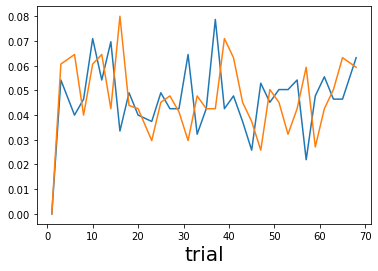

In [280]:
switch_on.mean(axis=0).plot()
switch_off.mean(axis=0).plot()

<AxesSubplot:xlabel='trial'>

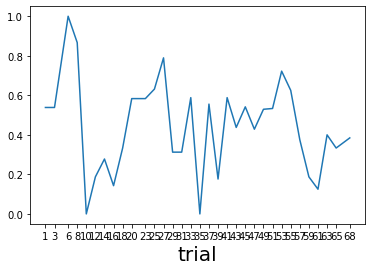

In [310]:
X_peaks.iloc[4].plot(xticks=X_peaks.columns)

In [302]:
switch_off.iloc[23]

trial
1.0     False
3.0     False
6.0     False
8.0     False
10.0    False
12.0    False
14.0    False
16.0    False
18.0    False
20.0    False
23.0    False
25.0    False
27.0    False
29.0    False
31.0    False
33.0    False
35.0    False
37.0    False
39.0    False
41.0    False
43.0    False
45.0    False
47.0    False
49.0    False
51.0    False
53.0    False
55.0    False
57.0    False
59.0    False
61.0     True
63.0    False
65.0    False
68.0     True
Name: (37, 1), dtype: bool

In [270]:
switch_on.sum()

trial
1.0      0
3.0     22
6.0     17
8.0     19
10.0    29
12.0    26
14.0    25
16.0    12
18.0    24
20.0     8
23.0    14
25.0    17
27.0    11
29.0    15
31.0    22
33.0    12
35.0    21
37.0    28
39.0    29
41.0    12
43.0    15
45.0     6
47.0    27
49.0    17
51.0    15
53.0    15
55.0    21
57.0     7
59.0    17
61.0    32
63.0    16
65.0    26
68.0    23
dtype: int64

In [268]:
switch_on.mean()

trial
1.0     0.000000
3.0     0.028387
6.0     0.021935
8.0     0.024516
10.0    0.037419
12.0    0.033548
14.0    0.032258
16.0    0.015484
18.0    0.030968
20.0    0.010323
23.0    0.018065
25.0    0.021935
27.0    0.014194
29.0    0.019355
31.0    0.028387
33.0    0.015484
35.0    0.027097
37.0    0.036129
39.0    0.037419
41.0    0.015484
43.0    0.019355
45.0    0.007742
47.0    0.034839
49.0    0.021935
51.0    0.019355
53.0    0.019355
55.0    0.027097
57.0    0.009032
59.0    0.021935
61.0    0.041290
63.0    0.020645
65.0    0.033548
68.0    0.029677
dtype: float64

In [236]:
X_peaks_filt=X_peaks.iloc[field_sorted_inds].loc[field_mask]

In [237]:
X_peaks_filt

,trial,1.0,3.0,6.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,...,49.0,51.0,53.0,55.0,57.0,59.0,61.0,63.0,65.0,68.0
,lin_binned,,,,,,,,,,,,,,,,,,,,,
262,1,0.000000,0.000000,0.000000,0.068571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
194,6,0.000000,0.000000,0.080214,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.043042,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
283,3,0.056088,0.000000,0.000000,0.033497,0.000000,0.040196,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
31,3,0.048626,0.052273,0.000000,0.000000,0.113022,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058081,0.000000,0.000000,0.000000,0.000000
254,5,0.052307,0.016583,0.009312,0.023971,0.000000,0.000000,0.005657,0.000000,0.004862,0.027764,...,0.007337,0.000000,0.004386,0.000000,0.000000,0.005578,0.008070,0.007519,0.017418,0.009000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,6,0.000000,0.252525,0.206612,0.129870,0.324675,0.270563,0.151515,0.329912,0.227273,0.206612,...,0.653798,0.202520,0.383044,0.609756,0.673401,0.568182,1.000000,0.373134,0.641026,0.153218
126,3,0.000000,0.069643,0.122180,0.128968,0.527027,0.526190,0.464286,0.825397,0.451020,0.316109,...,0.451020,0.647186,0.684211,0.232143,0.533929,0.490079,0.667411,0.294425,0.301484,0.325000
480,8,0.068878,0.562500,0.086873,0.576355,0.363354,0.794118,0.231140,0.292948,0.296703,0.391304,...,0.631169,0.339089,0.239574,0.332512,0.721254,0.302521,1.000000,0.741758,0.000000,0.152847


In [125]:
np.set_printoptions(precision=3,suppress=True)

(array([1772.,  509.,  271.,  188.,  149.,   93.,   70.,   31.,   15.,
           2.]),
 array([0.   , 0.094, 0.188, 0.283, 0.377, 0.471, 0.565, 0.66 , 0.754,
        0.848, 0.942]),
 <BarContainer object of 10 artists>)

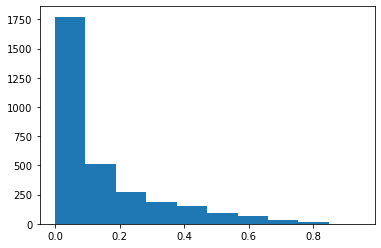

In [199]:
plt.hist(model.means_.flatten())

<AxesSubplot:xlabel='trial'>

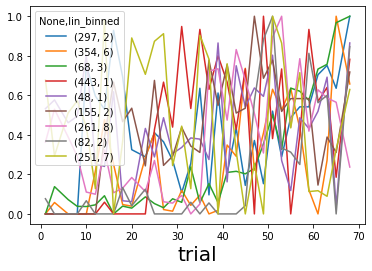

In [200]:


X_peaks.iloc[field_sorted_inds].loc[field_mask].iloc[380:400].T.plot()

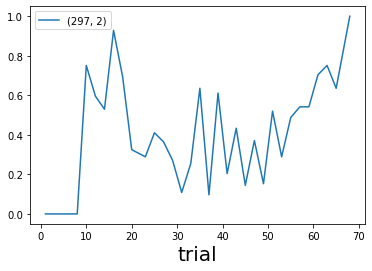

In [207]:
X_peaks.iloc[field_sorted_inds].loc[field_mask].iloc[380:400].iloc[0].plot()
plt.legend()

In [210]:

X=X_peaks.values
nfields,ntrials=X.shape
nrepeats=200
X_all_roll = np.array([np.roll(X,i,axis=1) for i in range(X.shape[1])])

new_start_inds=np.random.randint(ntrials-1,size=(nrepeats,nfields))

X_sim_l=np.array([X_all_roll[new_start_inds[i],np.arange(nfields)] for i in range(new_start_inds.shape[0])])
# X_sim_l=[]


In [77]:
X_sim = X_sim_l[0]
model=GaussianHMM(n_components=4)

array([[ 0.        ,  0.        ,  0.        , ...,  0.38961038,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.78947367, ...,  1.4634146 ,
         1.55844153,  3.74999993],
       [17.99999964, 16.9565214 , 13.99999972, ..., 24.37499951,
        28.12499944, 37.99999924],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.5664335 ,  1.60714283, 13.12499974, ..., 23.33333287,
        17.30769196,  0.        ]])

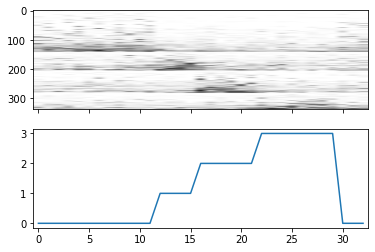

In [234]:
X_sim = X_sim_l[1]
model=GaussianHMM(n_components=4)
model.fit(X_sim.T)
predicted_state=model.predict_proba(X_sim.T)
state_relabel=na.sort_by_peak_within_factor(predicted_state.T)[0]
predicted_state = predicted_state[:,state_relabel]
predicted_state_one = np.argmax(predicted_state,axis=1)


emission =model.means_[state_relabel]
clust=np.argmax(model.means_[state_relabel],axis=0)

field_mask=np.any(model.means_[state_relabel]>0.2,axis=0)
field_sorted_inds= na.sort_factors(emission.T)[0]

fig,axs=plt.subplots(2,1,sharex=True)
axs[0].imshow(X_sim[field_sorted_inds][field_mask],aspect='auto')
# plt.colorbar()
axs[1].plot(predicted_state_one)

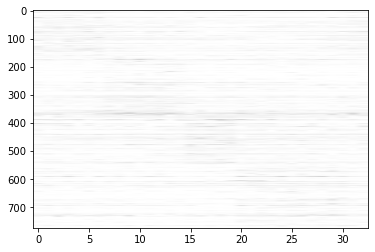

In [105]:
X_sim = X_sim_l[23]
model=GaussianHMM(n_components=4)
model.fit(X_sim.T)
predicted_state=model.predict_proba(X_sim.T)

state_relabel=na.sort_by_peak_within_factor(predicted_state.T)[0]

clust=np.argmax(model.means_[state_relabel],axis=0)

idx=np.argsort(clust)
X_peaks.iloc[idx]


plt.imshow(X_sim[idx],aspect='auto')